In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# 1It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [ ]:
train = get_training_data("/content/drive/MyDrive/Pneumonia/chest_xray/train")
test = get_training_data("/content/drive/MyDrive/Pneumonia/chest_xray/test")
val = get_training_data("/content/drive/MyDrive/Pneumonia/chest_xray/val")

<ipython-input-4-f7c995ea1462>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Data Visualization & Preprocessing

<Axes: xlabel='Category', ylabel='count'>

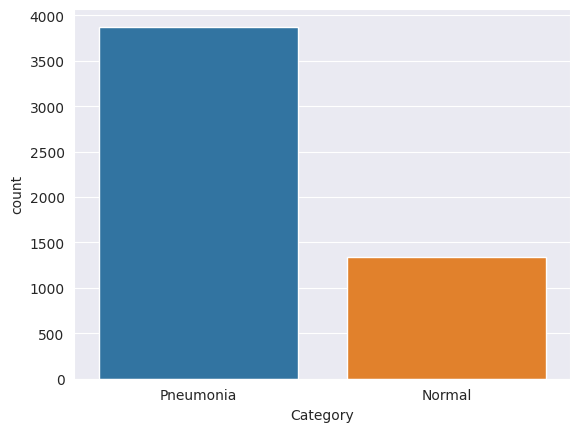

In [ ]:
import seaborn as sns
import pandas as pd

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(data=pd.DataFrame(l, columns=["Category"]), x="Category")


**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

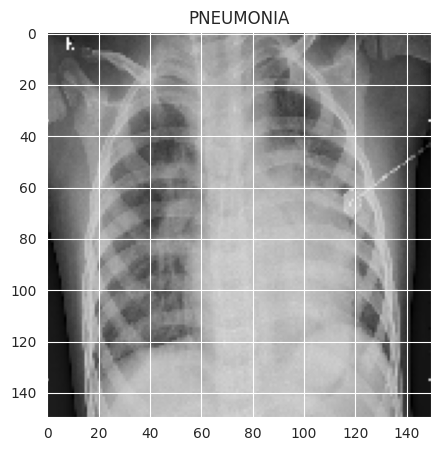

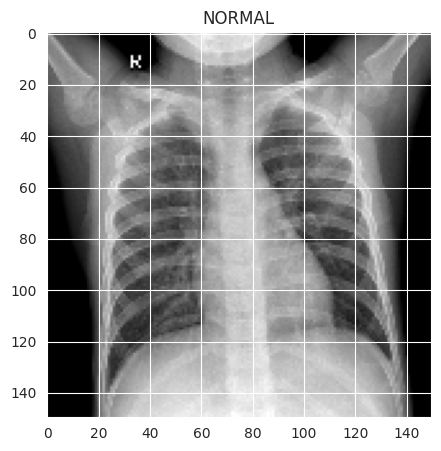

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 26s 87ms/step - loss: 0.7253 - accuracy: 0.8336 - val_loss: 15.1126 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 14s 84ms/step - loss: 0.2604 - accuracy: 0.8999 - val_loss: 23.7883 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9141
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 14s 83ms/step - loss: 0.2305 - accuracy: 0.9141 - val_loss: 45.0449 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 14s 84ms/step - loss: 0.1513 - accuracy: 0.9431 - val_loss: 0.7238 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 14s 86ms/step - loss: 0.1514 - accuracy: 0.9505 - val_loss: 10.0709 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
163/163 [======================

In [ ]:
# Assuming you have trained your model and now want to save it
# Replace 'model_filename.h5' with the desired filename for your saved model
model_filename = 'pneumonia_detection_model.h5'
model.save(model_filename)

print(f"Model saved as {model_filename}")


Model saved as pneumonia_detection_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 11ms/step - loss: 0.2534 - accuracy: 0.8974
Loss of the model is -  0.25341731309890747
20/20 [==============================] - 0s 11ms/step - loss: 0.2534 - accuracy: 0.8974
Accuracy of the model is -  89.74359035491943 %


# Analysis after Model Training

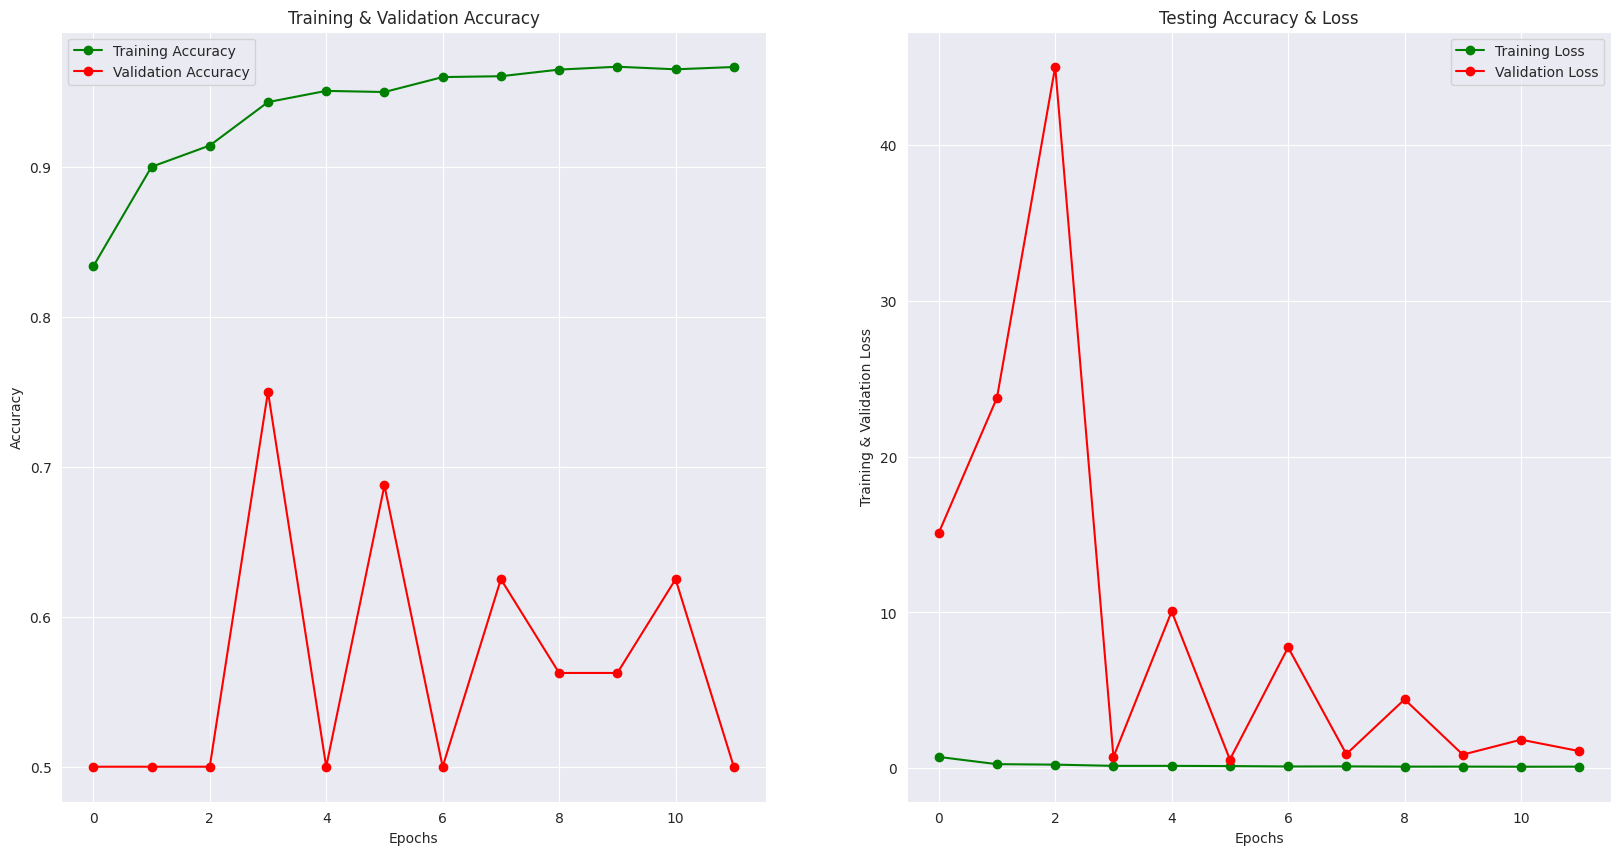

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
# predictions = model.predict_classes(x_test)
# predictions = predictions.reshape(1,-1)[0]
# predictions[:15]

In [ ]:
# Assuming you have imported your deep learning library and loaded the model already

# Make predictions on the test data
predictions_probabilities = model.predict(x_test)

# Extract the class with the highest probability for each example
predictions = [int(round(prob[0])) for prob in predictions_probabilities]

# Now you have the predicted classes in the 'predictions' list
predictions[:15]


20/20 [==============================] - 0s 9ms/step


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.97      0.92       390
   Normal (Class 1)       0.93      0.77      0.84       234

           accuracy                           0.89       624
          macro avg       0.90      0.87      0.88       624
       weighted avg       0.90      0.89      0.89       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[354,  36],
       [ 28, 206]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

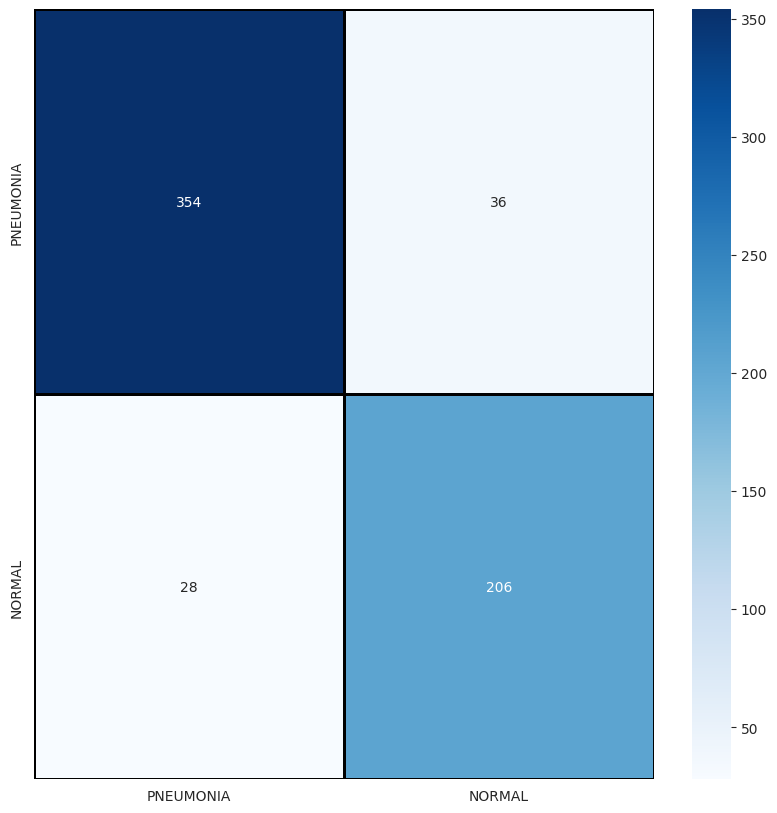

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

<ipython-input-23-3b0e8ec19e68>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


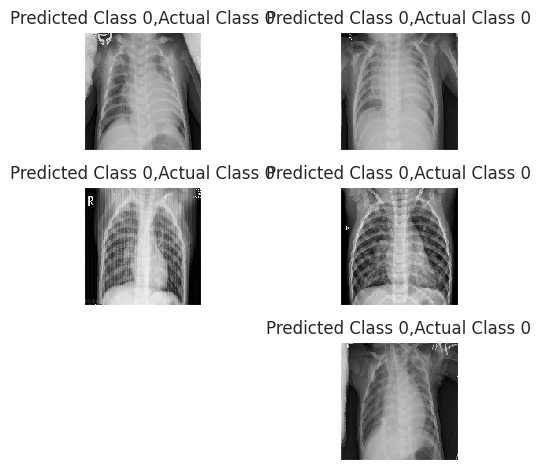

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

<ipython-input-24-d863d2b73908>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


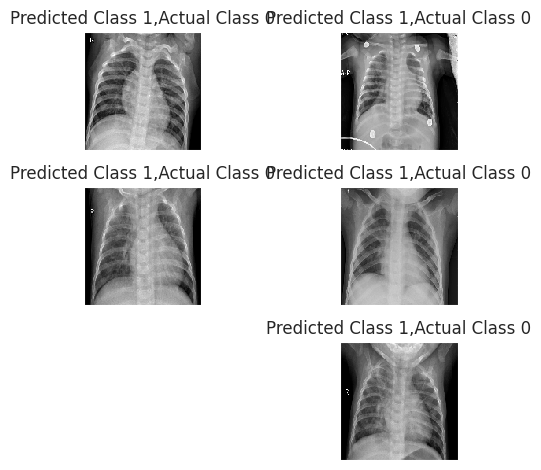

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
import numpy as np
import cv2
from keras.models import load_model

# Load the trained model
model_filename = 'pneumonia_detection_model.h5'
model = load_model(model_filename)

# Function to preprocess and predict an image
def predict_pneumonia(image_path, model):
    img_size = 150
    labels = ['PNEUMONIA', 'NORMAL']

    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Unable to load image at '{image_path}'")
        return None, None

    # Resize the image to the expected size
    img = cv2.resize(img, (img_size, img_size))

    # Normalize the image
    normalized_img = img / 255.0
    input_img = normalized_img.reshape(-1, img_size, img_size, 1)

    # Make a prediction
    prediction_probabilities = model.predict(input_img)
    prediction_class = int(round(prediction_probabilities[0][0]))
    prediction_label = labels[prediction_class]

    return prediction_label, prediction_probabilities[0][0]

# Example usage:
image_path = '/content/drive/MyDrive/Pneumonia/chest_xray/train/NORMAL/IM-0128-0001.jpeg'
predicted_label, confidence = predict_pneumonia(image_path, model)

if predicted_label is not None and confidence is not None:
    print(f'Predicted Label: {predicted_label}')
    print(f'Confidence: {confidence * 100:.2f}%')


1/1 [==============================] - 0s 438ms/step
Predicted Label: NORMAL
Confidence: 87.73%


1/1 [==============================] - 0s 407ms/step
Predicted Label: NORMAL
Confidence: 98.84%


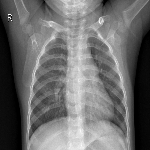

In [ ]:
import numpy as np
import cv2
from keras.models import load_model
from google.colab.patches import cv2_imshow

# Load the trained model
model_filename = 'pneumonia_detection_model.h5'
model = load_model(model_filename)

# Function to preprocess and predict an image
def predict_pneumonia(image_path, model):
    img_size = 150
    labels = ['PNEUMONIA', 'NORMAL']

    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Unable to load image at '{image_path}'")
        return None, None

    # Resize the image to the expected size
    img = cv2.resize(img, (img_size, img_size))

    # Normalize the image
    normalized_img = img / 255.0
    input_img = normalized_img.reshape(-1, img_size, img_size, 1)

    # Make a prediction
    prediction_probabilities = model.predict(input_img)
    prediction_class = int(round(prediction_probabilities[0][0]))
    prediction_label = labels[prediction_class]

    return prediction_label, prediction_probabilities[0][0], img

# Example usage:
image_path = '/content/drive/MyDrive/Pneumonia/chest_xray/test/NORMAL/IM-0067-0001.jpeg'
predicted_label, confidence, predicted_img = predict_pneumonia(image_path, model)

if predicted_label is not None and confidence is not None:
    print(f'Predicted Label: {predicted_label}')
    print(f'Confidence: {confidence * 100:.2f}%')

# Display the predicted image
cv2_imshow(predicted_img)


In [ ]:
######

#####INCEPTION V3

In [ ]:
import numpy as np

# Assuming train and val are lists of tuples where each tuple contains (feature, label)

# Initialize lists to store RGB images and corresponding labels
x_train_rgb = []
x_val_rgb = []
y_train = []
y_val = []

x_test_rgb =[]
y_test = []

# Iterate through the training data
for feature, label in train:
    # Expand dimensions to convert grayscale image to RGB
    rgb_feature = np.repeat(feature, 3, axis=-1)
    x_train_rgb.append(rgb_feature)
    y_train.append(label)

# Iterate through the validation data
for feature, label in val:
    # Expand dimensions to convert grayscale image to RGB
    rgb_feature = np.repeat(feature, 3, axis=-1)
    x_val_rgb.append(rgb_feature)
    y_val.append(label)

# Convert lists to NumPy arrays
x_train_rgb = np.array(x_train_rgb)
x_val_rgb = np.array(x_val_rgb)
y_train = np.array(y_train)
y_val = np.array(y_val)

x_test_rgb = np.array(x_test_rgb)
y_test = np.array(y_test)

# Normalize the data
x_train_rgb = x_train_rgb / 255
x_val_rgb = x_val_rgb / 255

x_test_rgb =x_test_rgb/ 255

In [ ]:
# Correct the shape of the input data
x_train_rgb = x_train_rgb.reshape(-1, 150, 150, 3)  # Assuming x_train_rgb is already normalized
x_val_rgb = x_val_rgb.reshape(-1, 150, 150, 3)  # Assuming x_val_rgb is already normalized


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
import keras
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Create the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model_image = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_image.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now you can train the model
history = model_image.fit(datagen.flow(x_train_rgb, y_train, batch_size=32),
                    epochs=12,
                    validation_data=datagen.flow(x_val_rgb, y_val),
                    callbacks=[learning_rate_reduction])


87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/12
163/163 [==============================] - 54s 226ms/step - loss: 0.3153 - accuracy: 0.8677 - val_loss: 0.5697 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 32s 199ms/step - loss: 0.2055 - accuracy: 0.9126 - val_loss: 0.5714 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9168
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 33s 205ms/step - loss: 0.2138 - accuracy: 0.9168 - val_loss: 1.1747 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 33s 200ms/step - loss: 0.1727 - accuracy: 0.9308 - val_loss: 1.1583 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9312
Epoch 5: ReduceLROnPlateau reducing learni

In [ ]:
model_filename = 'pneumonia_detection_model_image.h5'
model_image.save(model_filename)

print(f"Model saved as {model_filename}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as pneumonia_detection_model_image.h5


In [ ]:
# Print the overall loss and accuracy
print("Overall Training Loss:", history.history['loss'][-1])
print("Overall Training Accuracy:", history.history['accuracy'][-1])
print("Overall Validation Loss:", history.history['val_loss'][-1])
print("Overall Validation Accuracy:", history.history['val_accuracy'][-1])



Overall Training Loss: 0.15264615416526794
Overall Training Accuracy: 0.9375
Overall Validation Loss: 0.9769130945205688
Overall Validation Accuracy: 0.625


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained pneumonia detection model based on InceptionV3
model_filename = 'pneumonia_detection_model_image.h5'
model_pneumonia = load_model(model_filename)

# Define labels for classes (PNEUMONIA and NORMAL)
labels = ['PNEUMONIA', 'NORMAL']

# Function to preprocess and predict an image for pneumonia
def predict_pneumonia_image(image_path, model):
    img_size = (150, 150)  # InceptionV3 input size

    # Load and preprocess the image using OpenCV and Keras preprocessing
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make a prediction
    prediction_probabilities = model.predict(img)
    predicted_class_index = int(round(prediction_probabilities[0][0]))
    predicted_label = labels[predicted_class_index]
    confidence = prediction_probabilities[0][0]

    return predicted_label, confidence

# Example usage:
image_path = '/content/IM-0086-0001.jpeg'  # Replace with the path to your test image
predicted_label, confidence = predict_pneumonia_image(image_path, model_pneumonia)
print(f'Predicted Label: {predicted_label}')
print(f'Confidence: {confidence * 100:.2f}%')


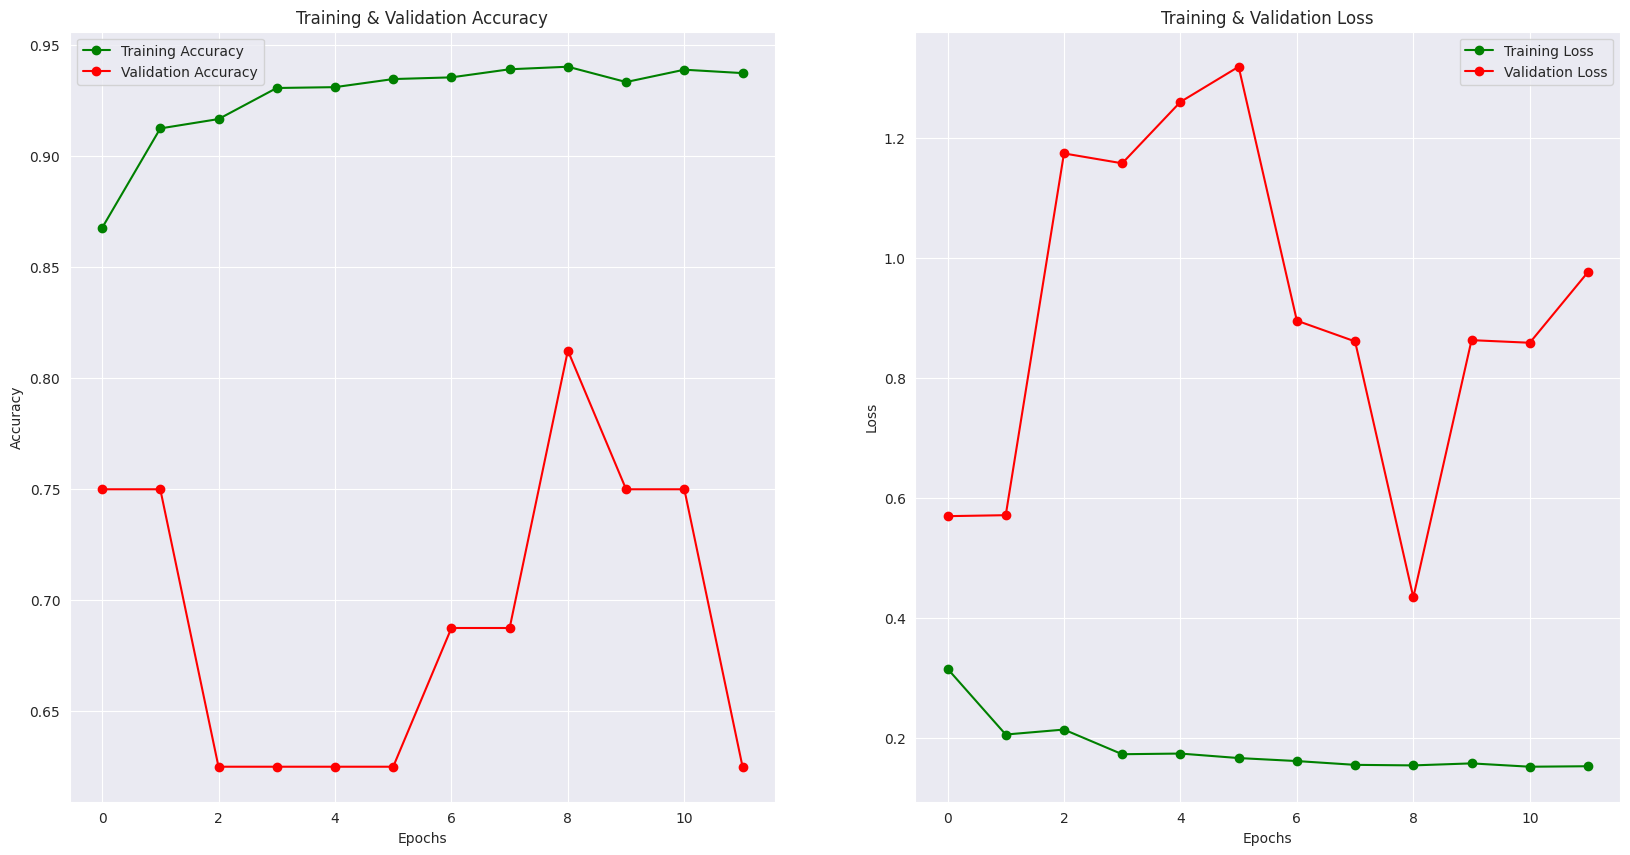

In [ ]:
# import matplotlib.pyplot as plt

# epochs = [i for i in range(12)]
# fig, ax = plt.subplots(1, 2)

# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']

# fig.set_size_inches(20, 10)

# # Plot Training and Validation Accuracy
# ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
# ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# # Plot Training and Validation Loss
# ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
# ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
# ax[1].set_title('Training & Validation Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Loss")

# plt.show()


In [ ]:
######after hyper parameter tuning

In [ ]:
import keras
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Create the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model_image = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_image.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now you can train the model
history = model_image.fit(datagen.flow(x_train_rgb, y_train, batch_size=64),
                    epochs=15,
                    validation_data=datagen.flow(x_val_rgb, y_val),
                    callbacks=[learning_rate_reduction])


Epoch 1/15
82/82 [==============================] - 44s 419ms/step - loss: 0.4149 - accuracy: 0.8545 - val_loss: 0.6297 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/15
82/82 [==============================] - 82s 1s/step - loss: 0.2103 - accuracy: 0.9158 - val_loss: 1.4024 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/15
82/82 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9156
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 33s 402ms/step - loss: 0.2016 - accuracy: 0.9156 - val_loss: 0.9005 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/15
82/82 [==============================] - 33s 400ms/step - loss: 0.1779 - accuracy: 0.9279 - val_loss: 0.8082 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/15
82/82 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9296
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
82/82 [==============================] - 33s 3

In [ ]:
model_filename = 'pneumonia_detection_model_image.h5'
model_image.save(model_filename)

print(f"Model saved as {model_filename}")

In [ ]:
# Print the overall loss and accuracy
print("Overall Training Loss:", history.history['loss'][-1])
print("Overall Training Accuracy:", history.history['accuracy'][-1])
print("Overall Validation Loss:", history.history['val_loss'][-1])
print("Overall Validation Accuracy:", history.history['val_accuracy'][-1])



Overall Training Loss: 0.14974355697631836
Overall Training Accuracy: 0.943443238735199
Overall Validation Loss: 0.6990841627120972
Overall Validation Accuracy: 0.625


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained pneumonia detection model based on InceptionV3
model_filename = 'pneumonia_detection_model_image.h5'
model_pneumonia = load_model(model_filename)

# Define labels for classes (PNEUMONIA and NORMAL)
labels = ['PNEUMONIA', 'NORMAL']

# Function to preprocess and predict an image for pneumonia
def predict_pneumonia_image(image_path, model):
    img_size = (150, 150)  # InceptionV3 input size

    # Load and preprocess the image using OpenCV and Keras preprocessing
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make a prediction
    prediction_probabilities = model.predict(img)
    predicted_class_index = int(round(prediction_probabilities[0][0]))
    predicted_label = labels[predicted_class_index]
    confidence = prediction_probabilities[0][0]

    return predicted_label, confidence

# Example usage:
image_path = '/content/IM-0086-0001.jpeg'  # Replace with the path to your test image
predicted_label, confidence = predict_pneumonia_image(image_path, model_pneumonia)
print(f'Predicted Label: {predicted_label}')
print(f'Confidence: {confidence * 100:.2f}%')
